In [1]:
using thesis, PRMaps
using Healpix
using Plots
using Statistics
using LsqFit
using Distributions
using LaTeXStrings
using JLD2

import Stripeline as Sl
import Pandas as Pd

In [2]:
function run_scaling(
    tel_angles,
    sky_model::String,
    nside::Int,
    setup::PRMaps.Setup
)
    
    strip = Pd.query(Pd.read_pickle("../instruments/lspe_strip_instrument.pkl"), :(frequency==43.0))
    signal = get_foreground_maps(strip, sky_model, nside)[1]

    camera = Sl.CameraAngles()
    ideal, _ = makeIdealMapIQU(camera, signal, setup)
    obs_ideal = HealpixMap{Float64, RingOrder}(ideal.i.resolution.nside)
    polDegreeMap!(obs_ideal, ideal.q, ideal.u)        

    maps_pol = HealpixMap[]

    for i in tel_angles
        m, _ = makeErroredMapIQU(camera, i, signal, setup)
        buffer = HealpixMap{Float64, RingOrder}(m.i.resolution.nside)
        polDegreeMap!(buffer, m.q, m.u)        
        push!(maps_pol, buffer)
    end

    error = [ (obs_ideal - errored) for errored in maps_pol]

    error_hist = [ i[isfinite.(i)] for i in error]

    distro_fit = [ fit(Cauchy, data) for data in error_hist ]

    sigma = [ scale(distro) for distro in distro_fit ]

    return sigma

end

run_scaling (generic function with 1 method)

In [3]:
nside = 512
sky_model = "s0"
obs_days = 10
 
setup = PRMaps.Setup(
    sampling_freq_Hz = 50.,
    total_time_s = 24. * 3600. * obs_days
    )
nothing

In [4]:
errored_angles_deg = [0.25/60, 0.5/60, 1.0/60, 5.0/60]
omega_wobble_deg = [0.0, 90.0, 180.0, 270.0]

errored_angles_arcsec = [15, 30, 60, 300]

xdata = log10.(range(minimum(errored_angles_arcsec), stop=maximum(errored_angles_arcsec), length=10000))

nothing

In [23]:
xlabel = L"\textrm{Configuration \ angle \ value} \ [\log_{10}(\textrm{arcsec})]"
ylabel = L"\textrm{Scale \ of \ the \ error \ distribution} \ [\log_{10}(\mu K)]"
nothing

# Altitude offset angle

In [24]:
tel_angs_altitude = []
for i in errored_angles_deg
    push!(tel_angs_altitude, Sl.TelescopeAngles(wheel2ang_0_rad = deg2rad(i)))
end
#result_altitude = run_scaling(tel_angs_altitude, sky_model, nside, setup)
#save_object("scaling/altitude.jld2", result_altitude)
result_altitude = load_object("scaling/altitude.jld2")
nothing

L'errore è fittato con la seguente funzione:

$\log\epsilon = p_1 \log^2 x + p_2 \log x + p_3$

con x l'angolo di non idealità.

In [25]:
@. model_linear(x,p) =  p[1]*x^2 + p[2]*x + p[3]

model_linear (generic function with 1 method)

In [26]:
log_error = log10.(result_altitude)
log_angle = log10.(errored_angles_arcsec)
fit_linear = curve_fit(model_linear, log_angle, log_error, [0.0, 0.5, 1.0])
print(fit_linear.param)

[-0.011050366816438955, 1.02794934081695, -3.588736918956649]

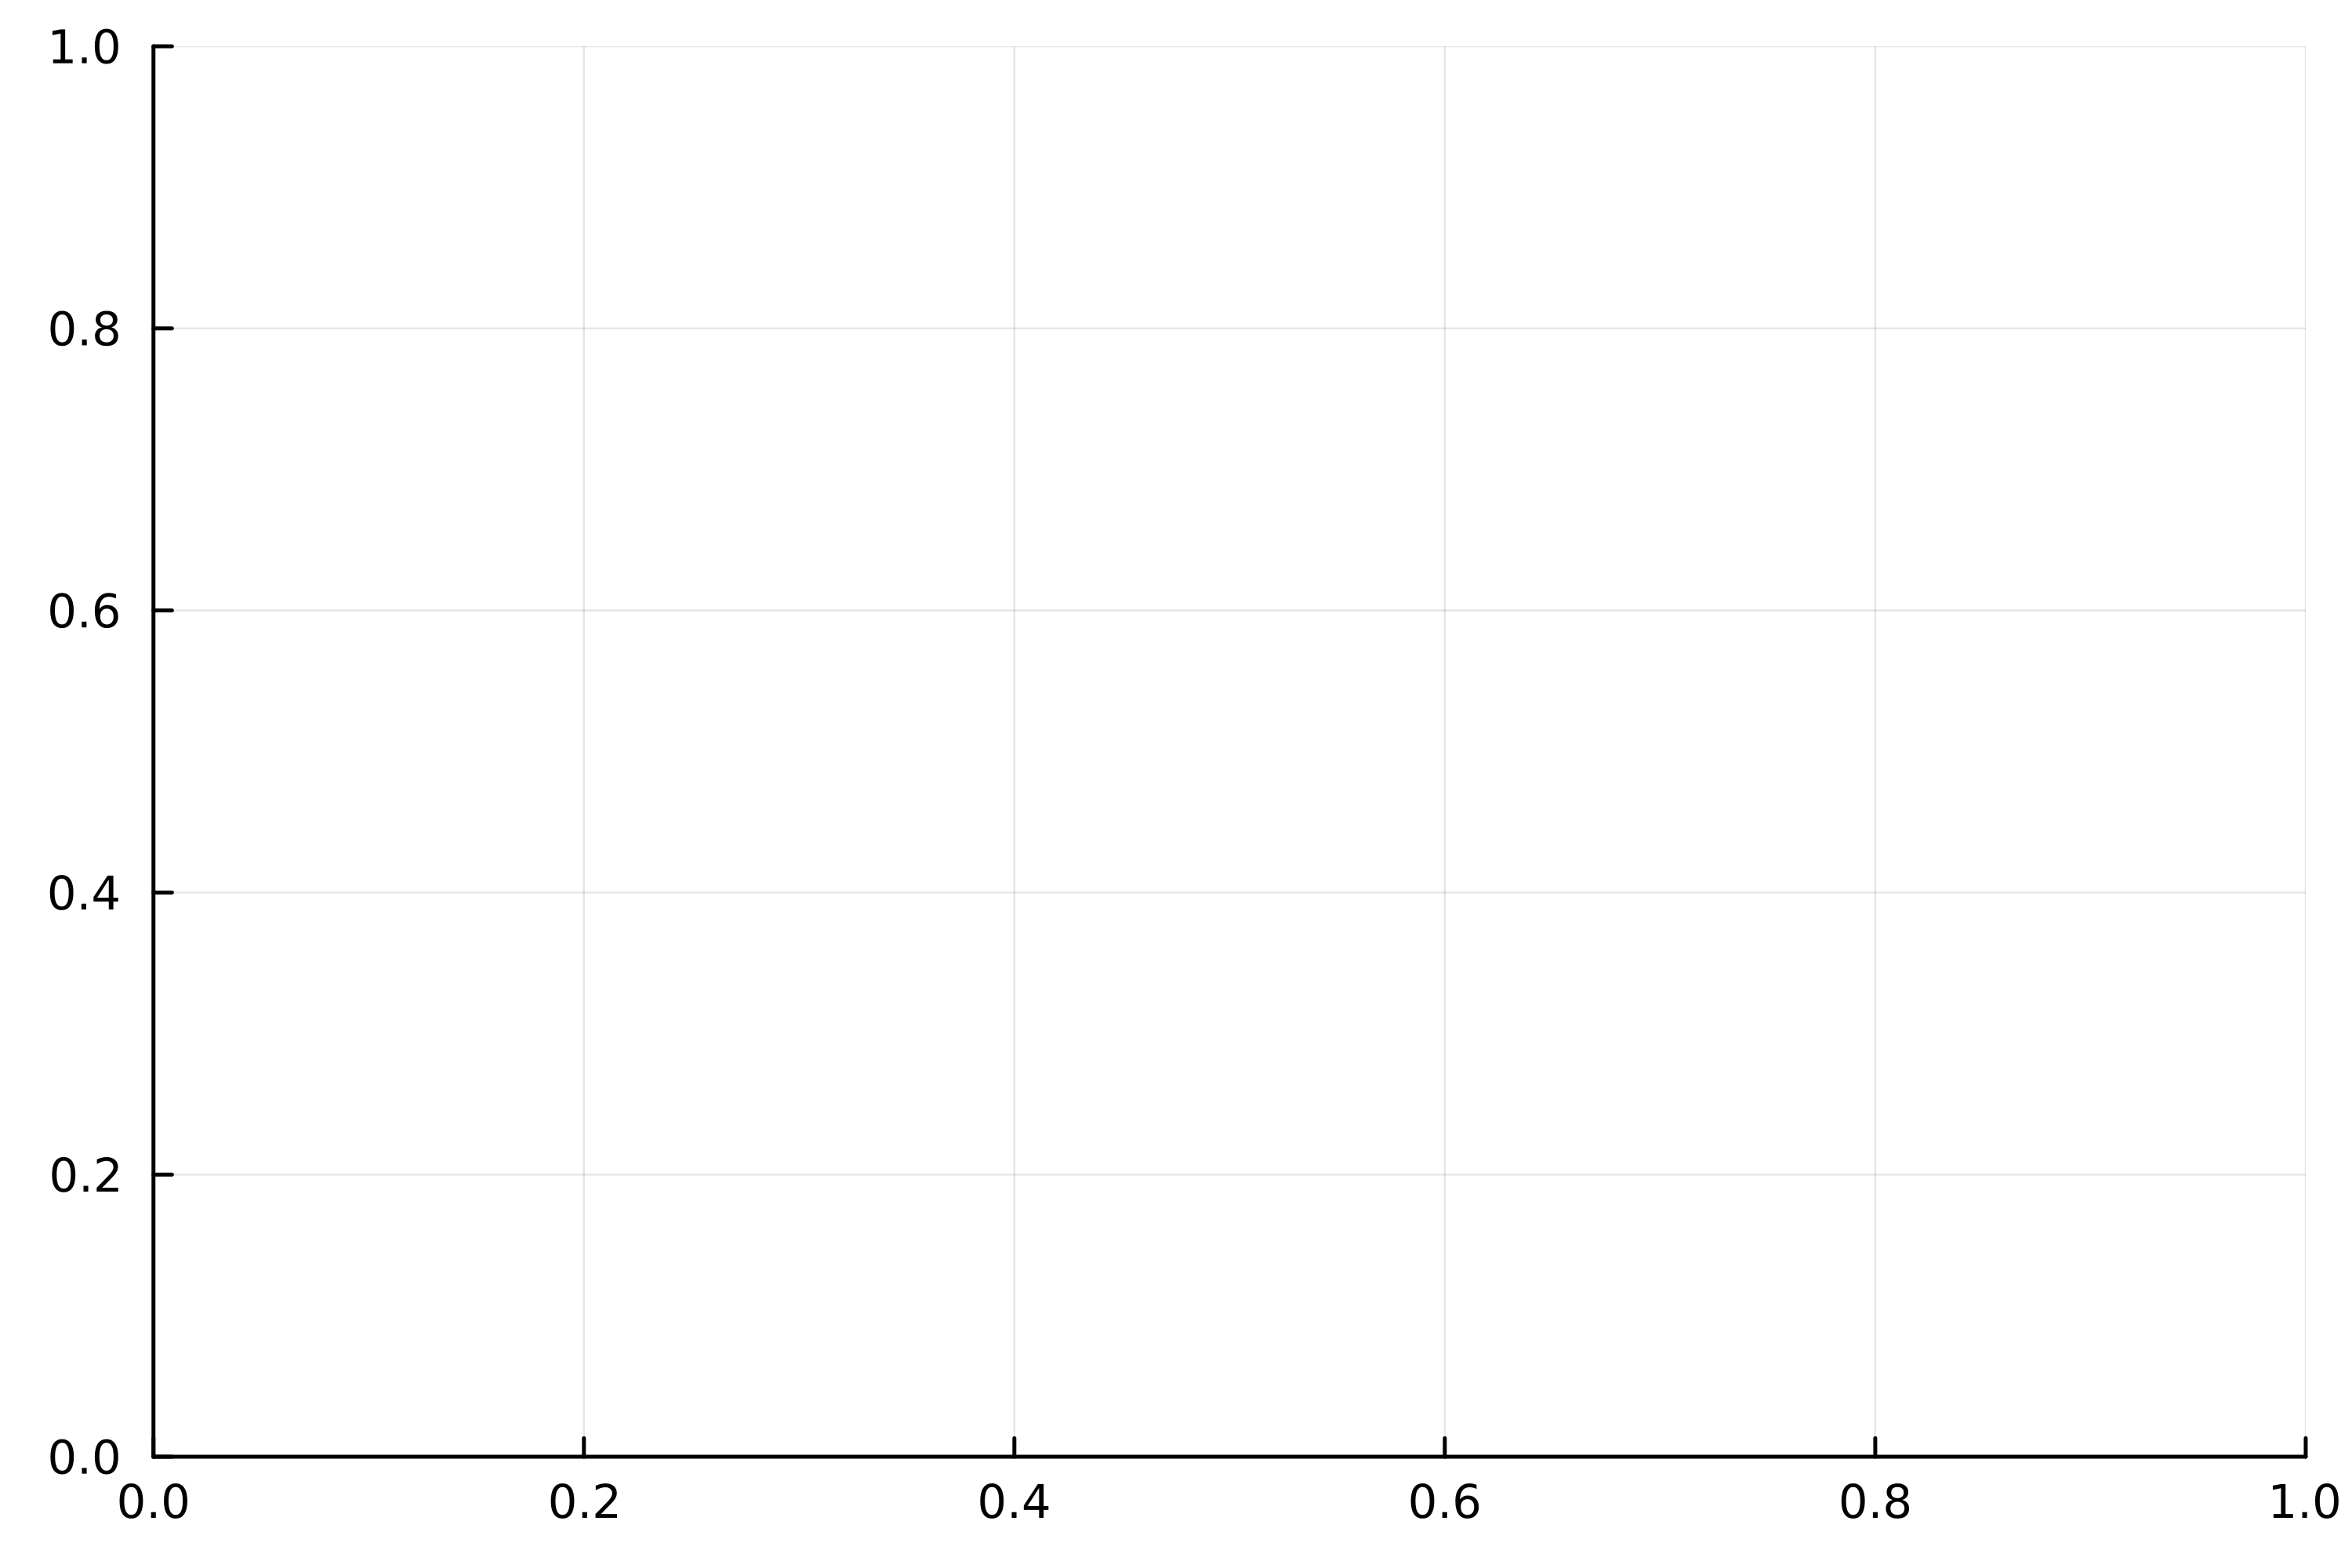

In [27]:
p = plot(linewidth = 1.5, marker = :circle, palette = :tol_light, dpi = 500)

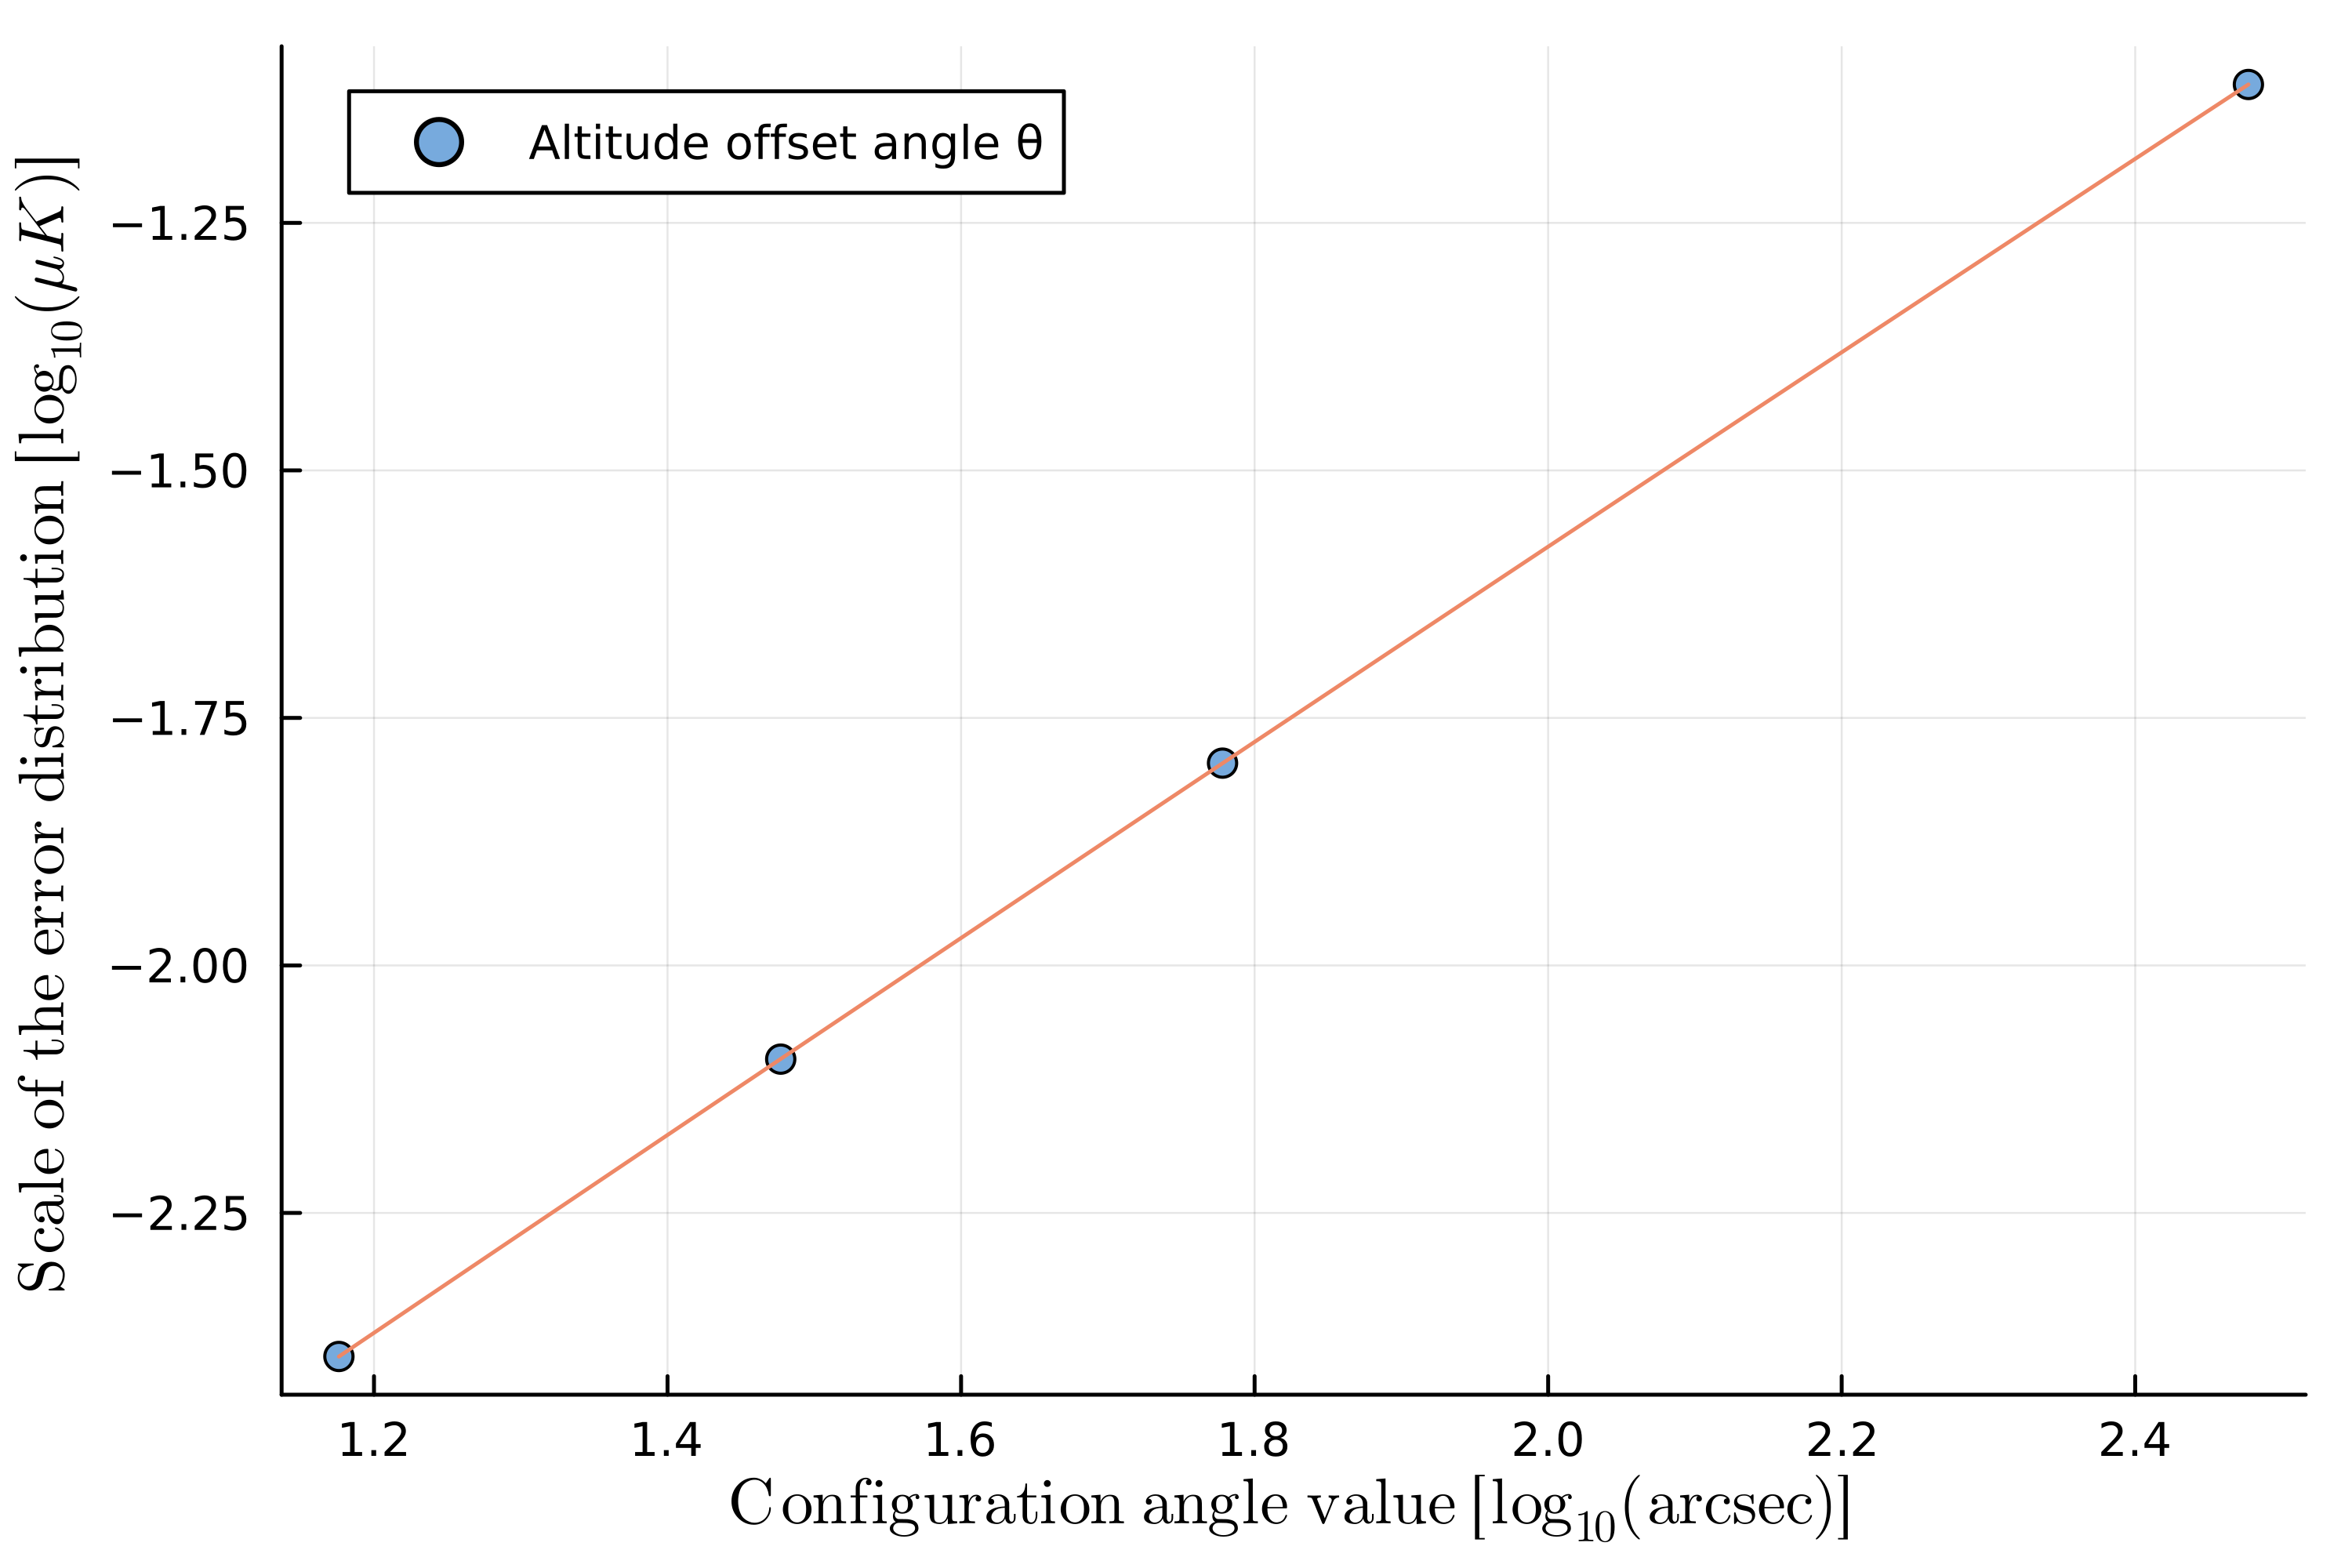

In [28]:
p = scatter!(log_angle, log_error, xlabel=xlabel, ylabel=ylabel, label = "Altitude offset angle θ")
p = plot!(xdata, model_linear(xdata, fit_linear.param), label = false)
#savefig("scaling/altitude.svg")

# Ground offset angle

In [29]:
tel_angs_ground = []
for i in errored_angles_deg
    push!(tel_angs_ground, Sl.TelescopeAngles(wheel3ang_0_rad = deg2rad(i)))
end
#result_ground = run_scaling(tel_angs_ground, sky_model, nside, setup)
#save_object("scaling/ground.jld2", result_ground)
result_ground = load_object("scaling/ground.jld2")

4-element Vector{Float64}:
 0.0011925434362068804
 0.0023904115999589387
 0.004788578417289802
 0.024587795895781334

In [30]:
log_error = log10.(result_ground)
log_angle = log10.(errored_angles_arcsec)
fit_linear = curve_fit(model_linear, log_angle, log_error, [0.0, 0.5, 1.0])
print(fit_linear.param)

[0.009697784414820526, 0.9744868982428628, -4.082774481693492]

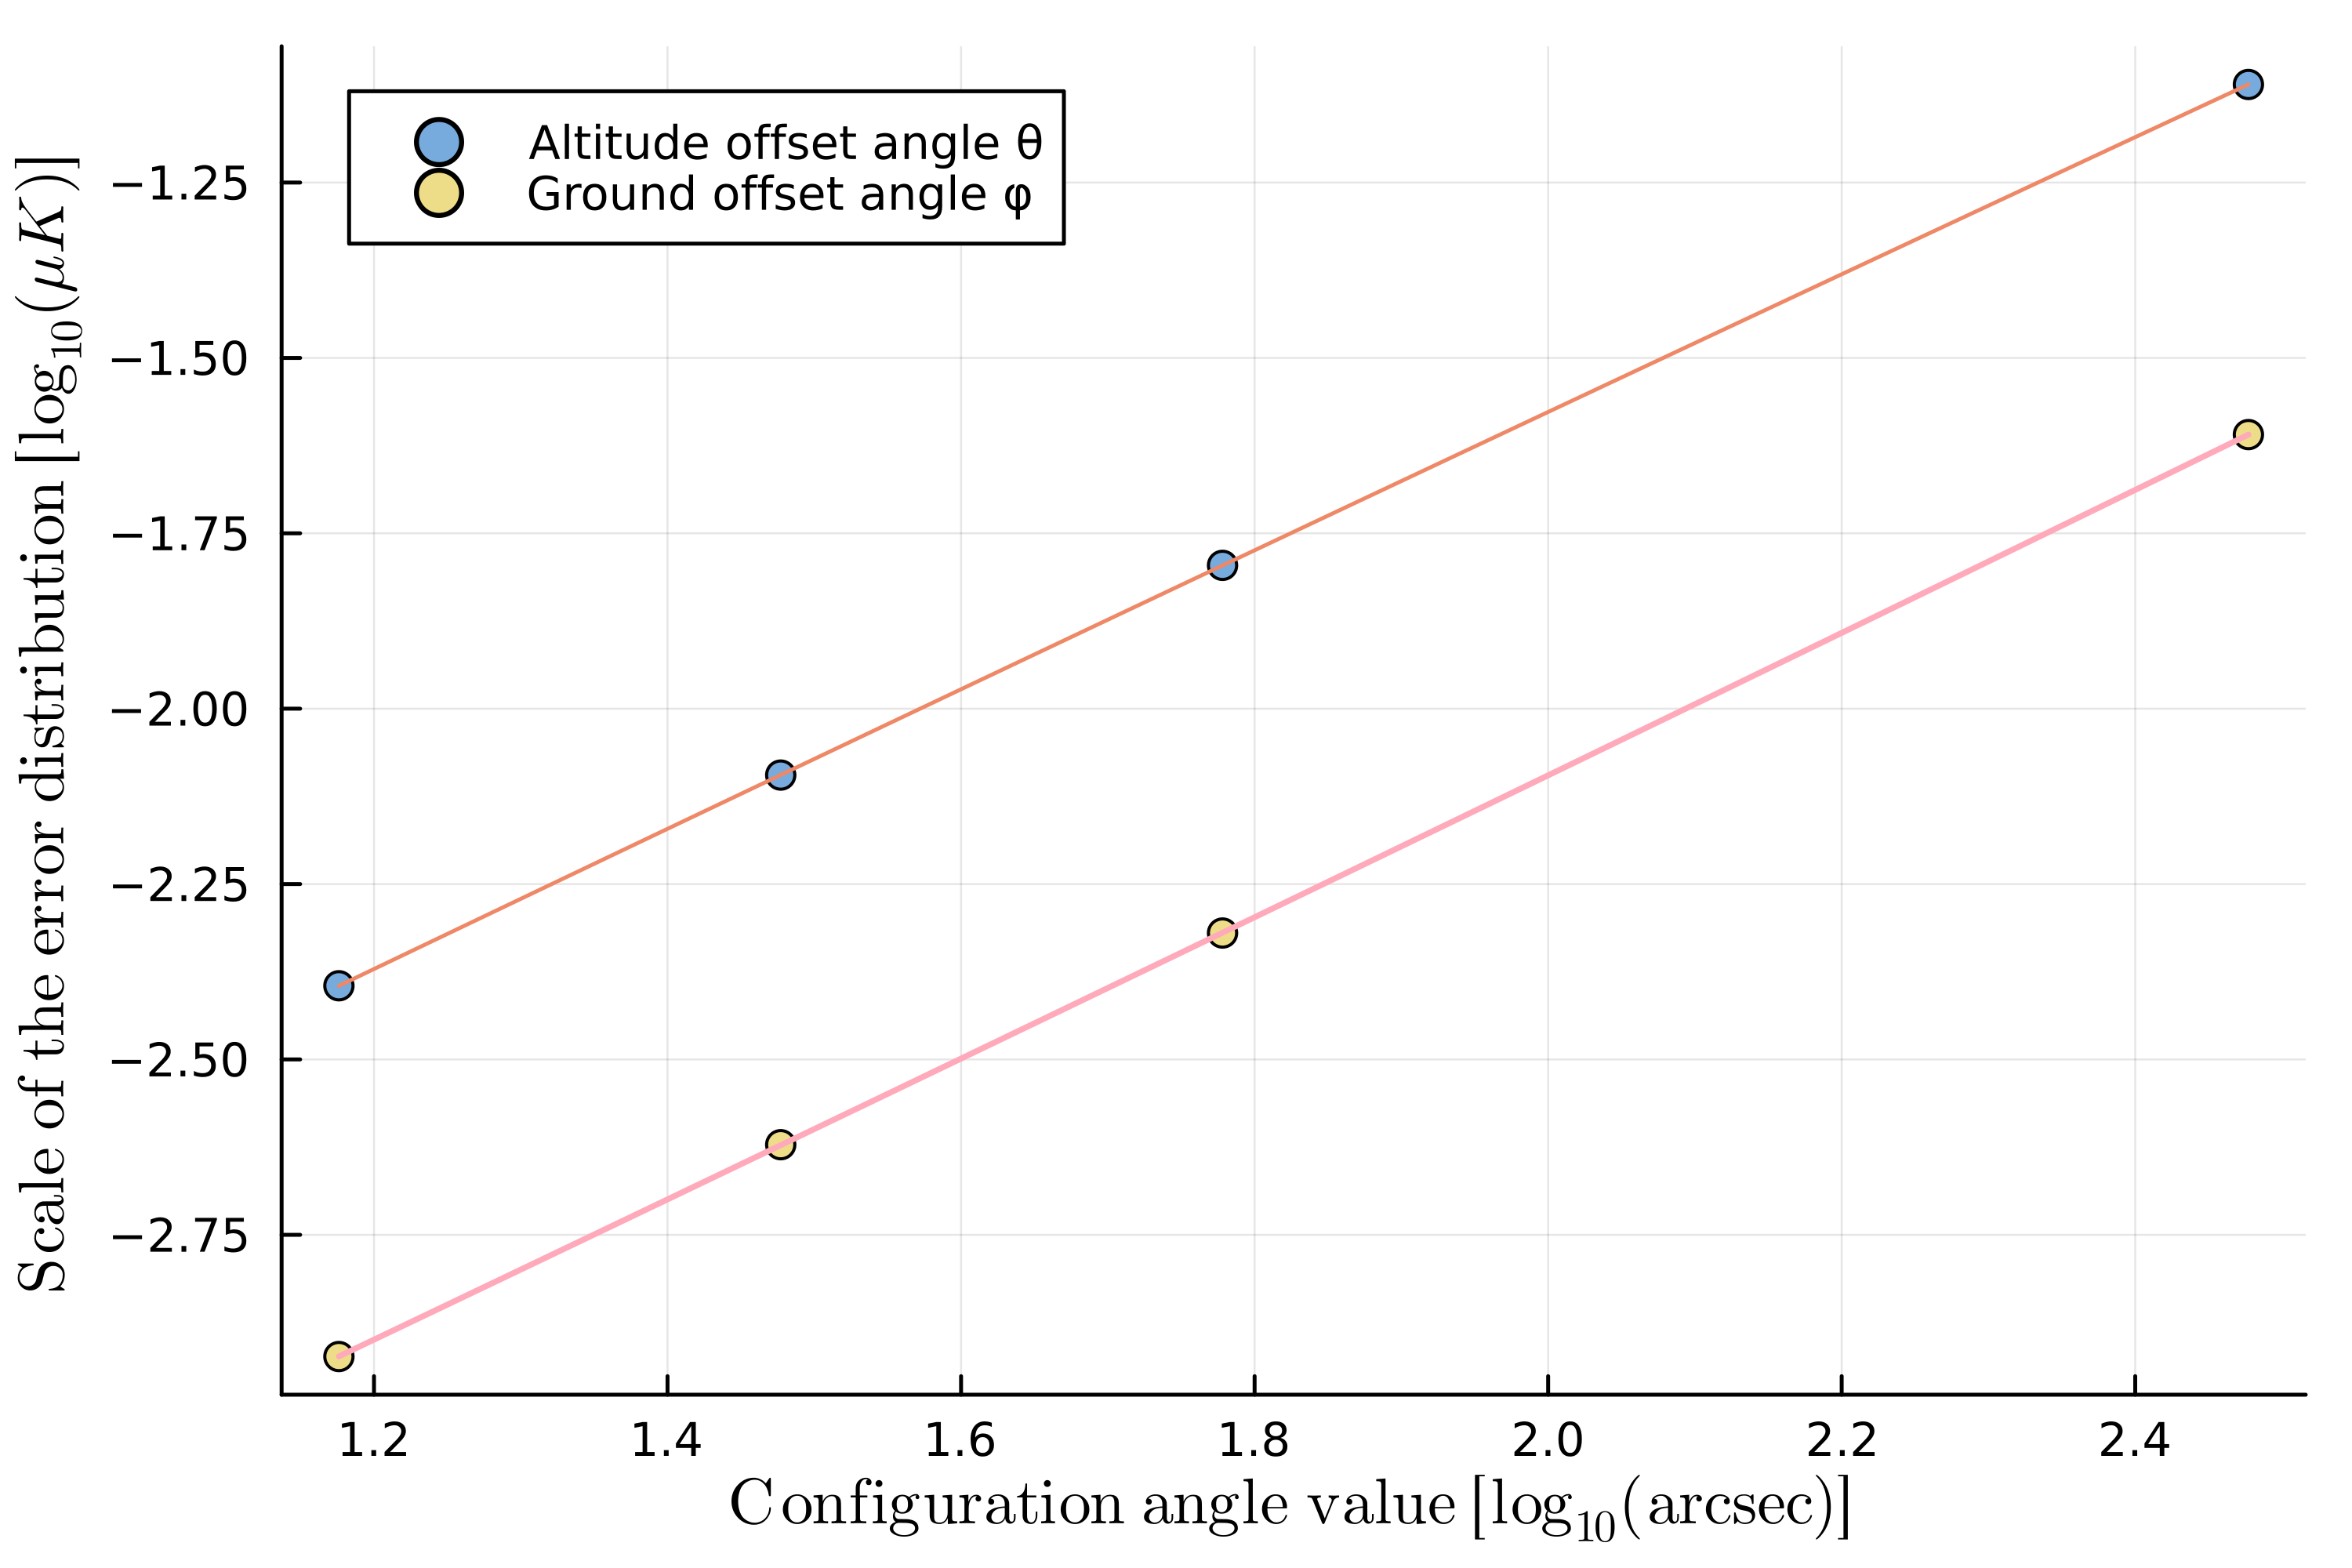

In [31]:
p = scatter!(log_angle, log_error, xlabel=xlabel, ylabel=ylabel, label = "Ground offset angle φ")
p = plot!(xdata, model_linear(xdata, fit_linear.param), label = false, linewidth = 1.5, palette = :tol_light, dpi = 500)

# Fork angle

In [32]:
tel_angs_fork = []
for i in errored_angles_deg
    push!(tel_angs_fork, Sl.TelescopeAngles(forkang_rad = deg2rad(i)))
end
#result_fork = run_scaling(tel_angs_fork, sky_model, nside, setup)
#save_object("scaling/fork.jld2", result_fork)
result_fork = load_object("scaling/fork.jld2")

4-element Vector{Float64}:
 0.0032866362579097586
 0.00659287170215099
 0.013293556440342857
 0.07343069269851915

In [33]:
log_error = log10.(result_fork)
log_angle = log10.(errored_angles_arcsec)
fit_linear = curve_fit(model_linear, log_angle, log_error, [0.0, 0.5, 1.0])
print(fit_linear.param)

[0.039333737194242824, 0.8926868609966394, -3.586929937389515]

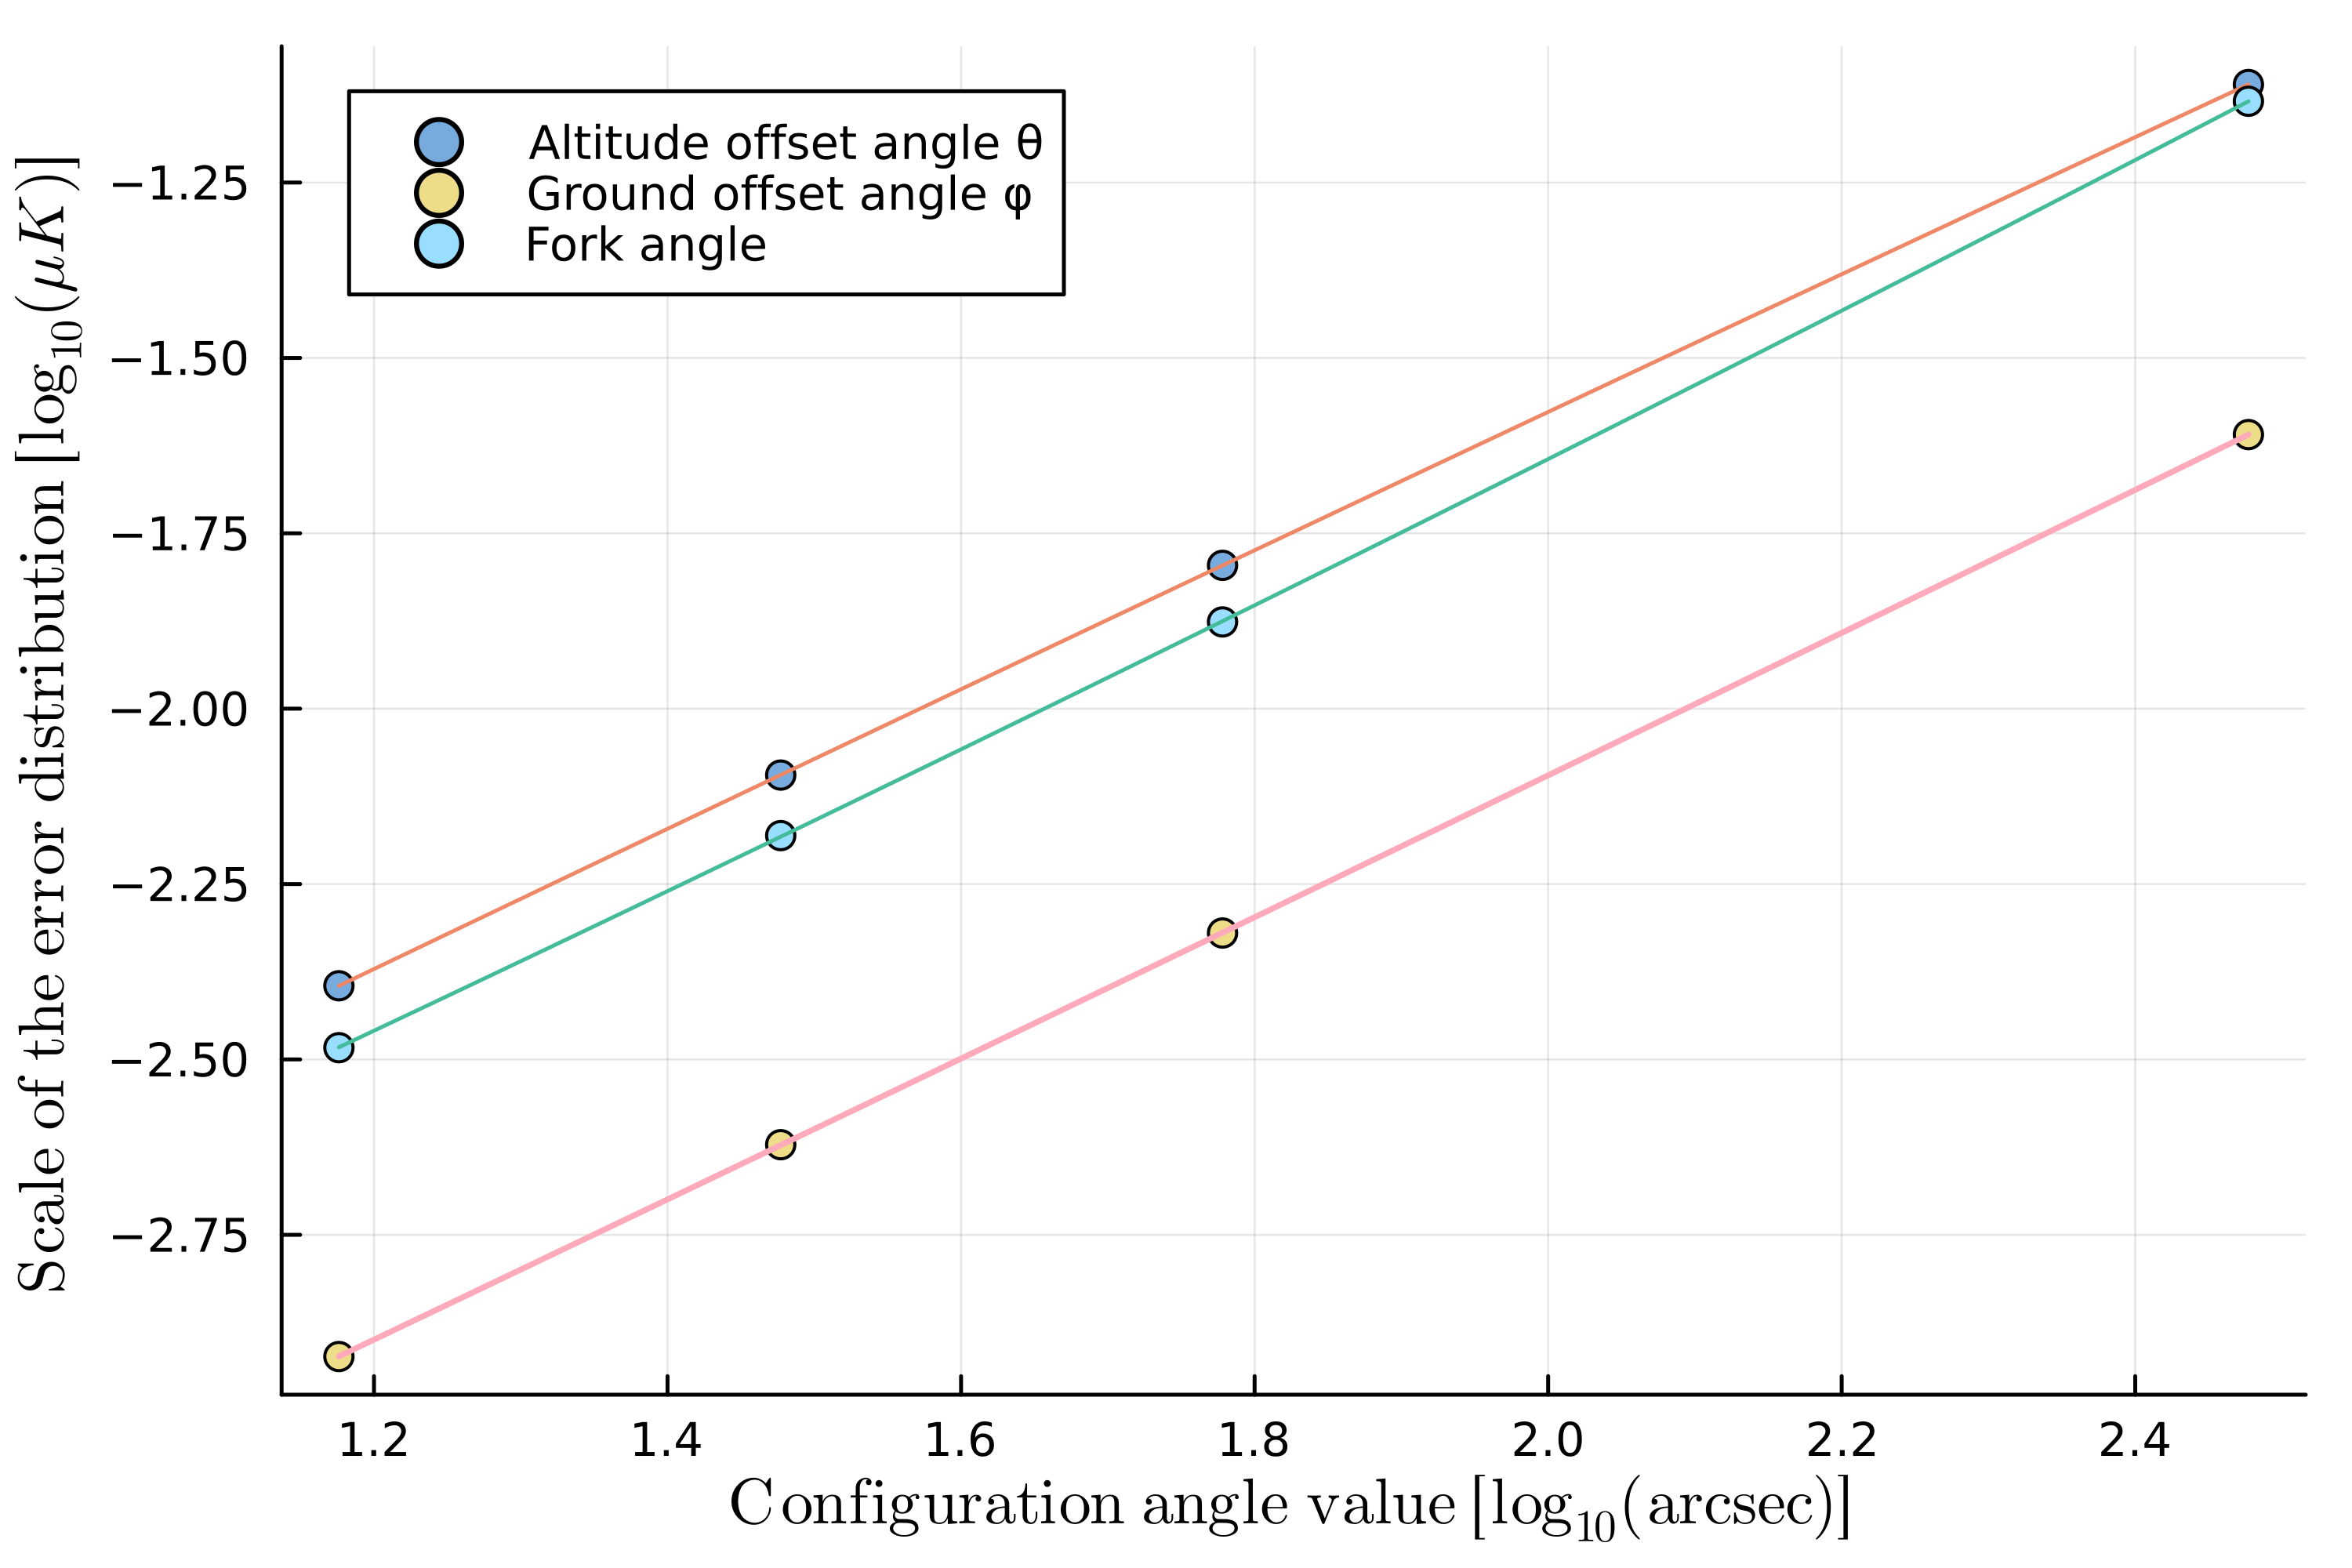

In [34]:
p = scatter!(log_angle, log_error, xlabel=xlabel, ylabel=ylabel, label = "Fork angle")
p = plot!(xdata, model_linear(xdata, fit_linear.param), label = false)

# Wobble angles

In [35]:
tel_angs_0 = []
tel_angs_90 = []
tel_angs_180 = []
tel_angs_270 = []

for i in errored_angles_deg
    push!(tel_angs_0, Sl.TelescopeAngles(zVAXang_rad = deg2rad(i), ωVAXang_rad = deg2rad(0.0)))
    push!(tel_angs_90, Sl.TelescopeAngles(zVAXang_rad = deg2rad(i), ωVAXang_rad = deg2rad(90.0)))
    push!(tel_angs_180, Sl.TelescopeAngles(zVAXang_rad = deg2rad(i), ωVAXang_rad = deg2rad(180.0)))
    push!(tel_angs_270, Sl.TelescopeAngles(zVAXang_rad = deg2rad(i), ωVAXang_rad = deg2rad(270.0)))
end

#result_0 = run_scaling(tel_angs_0, sky_model, nside, setup)
#result_90 = run_scaling(tel_angs_90, sky_model, nside, setup)
#result_180 = run_scaling(tel_angs_180, sky_model, nside, setup)
#result_270 = run_scaling(tel_angs_270, sky_model, nside, setup)

#save_object("scaling/wobble_0.jld2", result_0)
#save_object("scaling/wobble_90.jld2", result_90)
#save_object("scaling/wobble_180.jld2", result_180)
#save_object("scaling/wobble_270.jld2", result_270)

result_0 = load_object("scaling/wobble_0.jld2")
result_90 = load_object("scaling/wobble_90.jld2")
result_180 = load_object("scaling/wobble_180.jld2")
result_270 = load_object("scaling/wobble_270.jld2")


4-element Vector{Float64}:
 4.4152399156227595e-7
 1.7661003692548416e-6
 7.06448988035957e-6
 0.00017660661738951033

In [36]:
log_angle = log10.(errored_angles_arcsec)

log_error_0 = log10.(result_0)
log_error_90 = log10.(result_90)
log_error_180 = log10.(result_180)
log_error_270 = log10.(result_270)

fit_linear_0 = curve_fit(model_linear, log_angle, log_error_0, [0.0, 1.0, 1.0])
fit_linear_90 = curve_fit(model_linear, log_angle, log_error_90, [0.0, 1.0, 1.0])
fit_linear_180 = curve_fit(model_linear, log_angle, log_error_180, [0.0, 1.0, 1.0])
fit_linear_270 = curve_fit(model_linear, log_angle, log_error_270, [0.0, 1.0, 1.0])

print(fit_linear_0.param)
print(fit_linear_90.param)
print(fit_linear_180.param)
print(fit_linear_270.param)

[-1.1843036554717161e-5, 2.0000396512184504, -8.828881876787758][-3.1446214472468455e-5, 2.0000943195626895, -8.908903377276712][3.7825413893679906e-5, 1.9998888690689984, -8.828166471346464][-2.013902229288084e-5, 2.0000689013485733, -8.707282381119192]

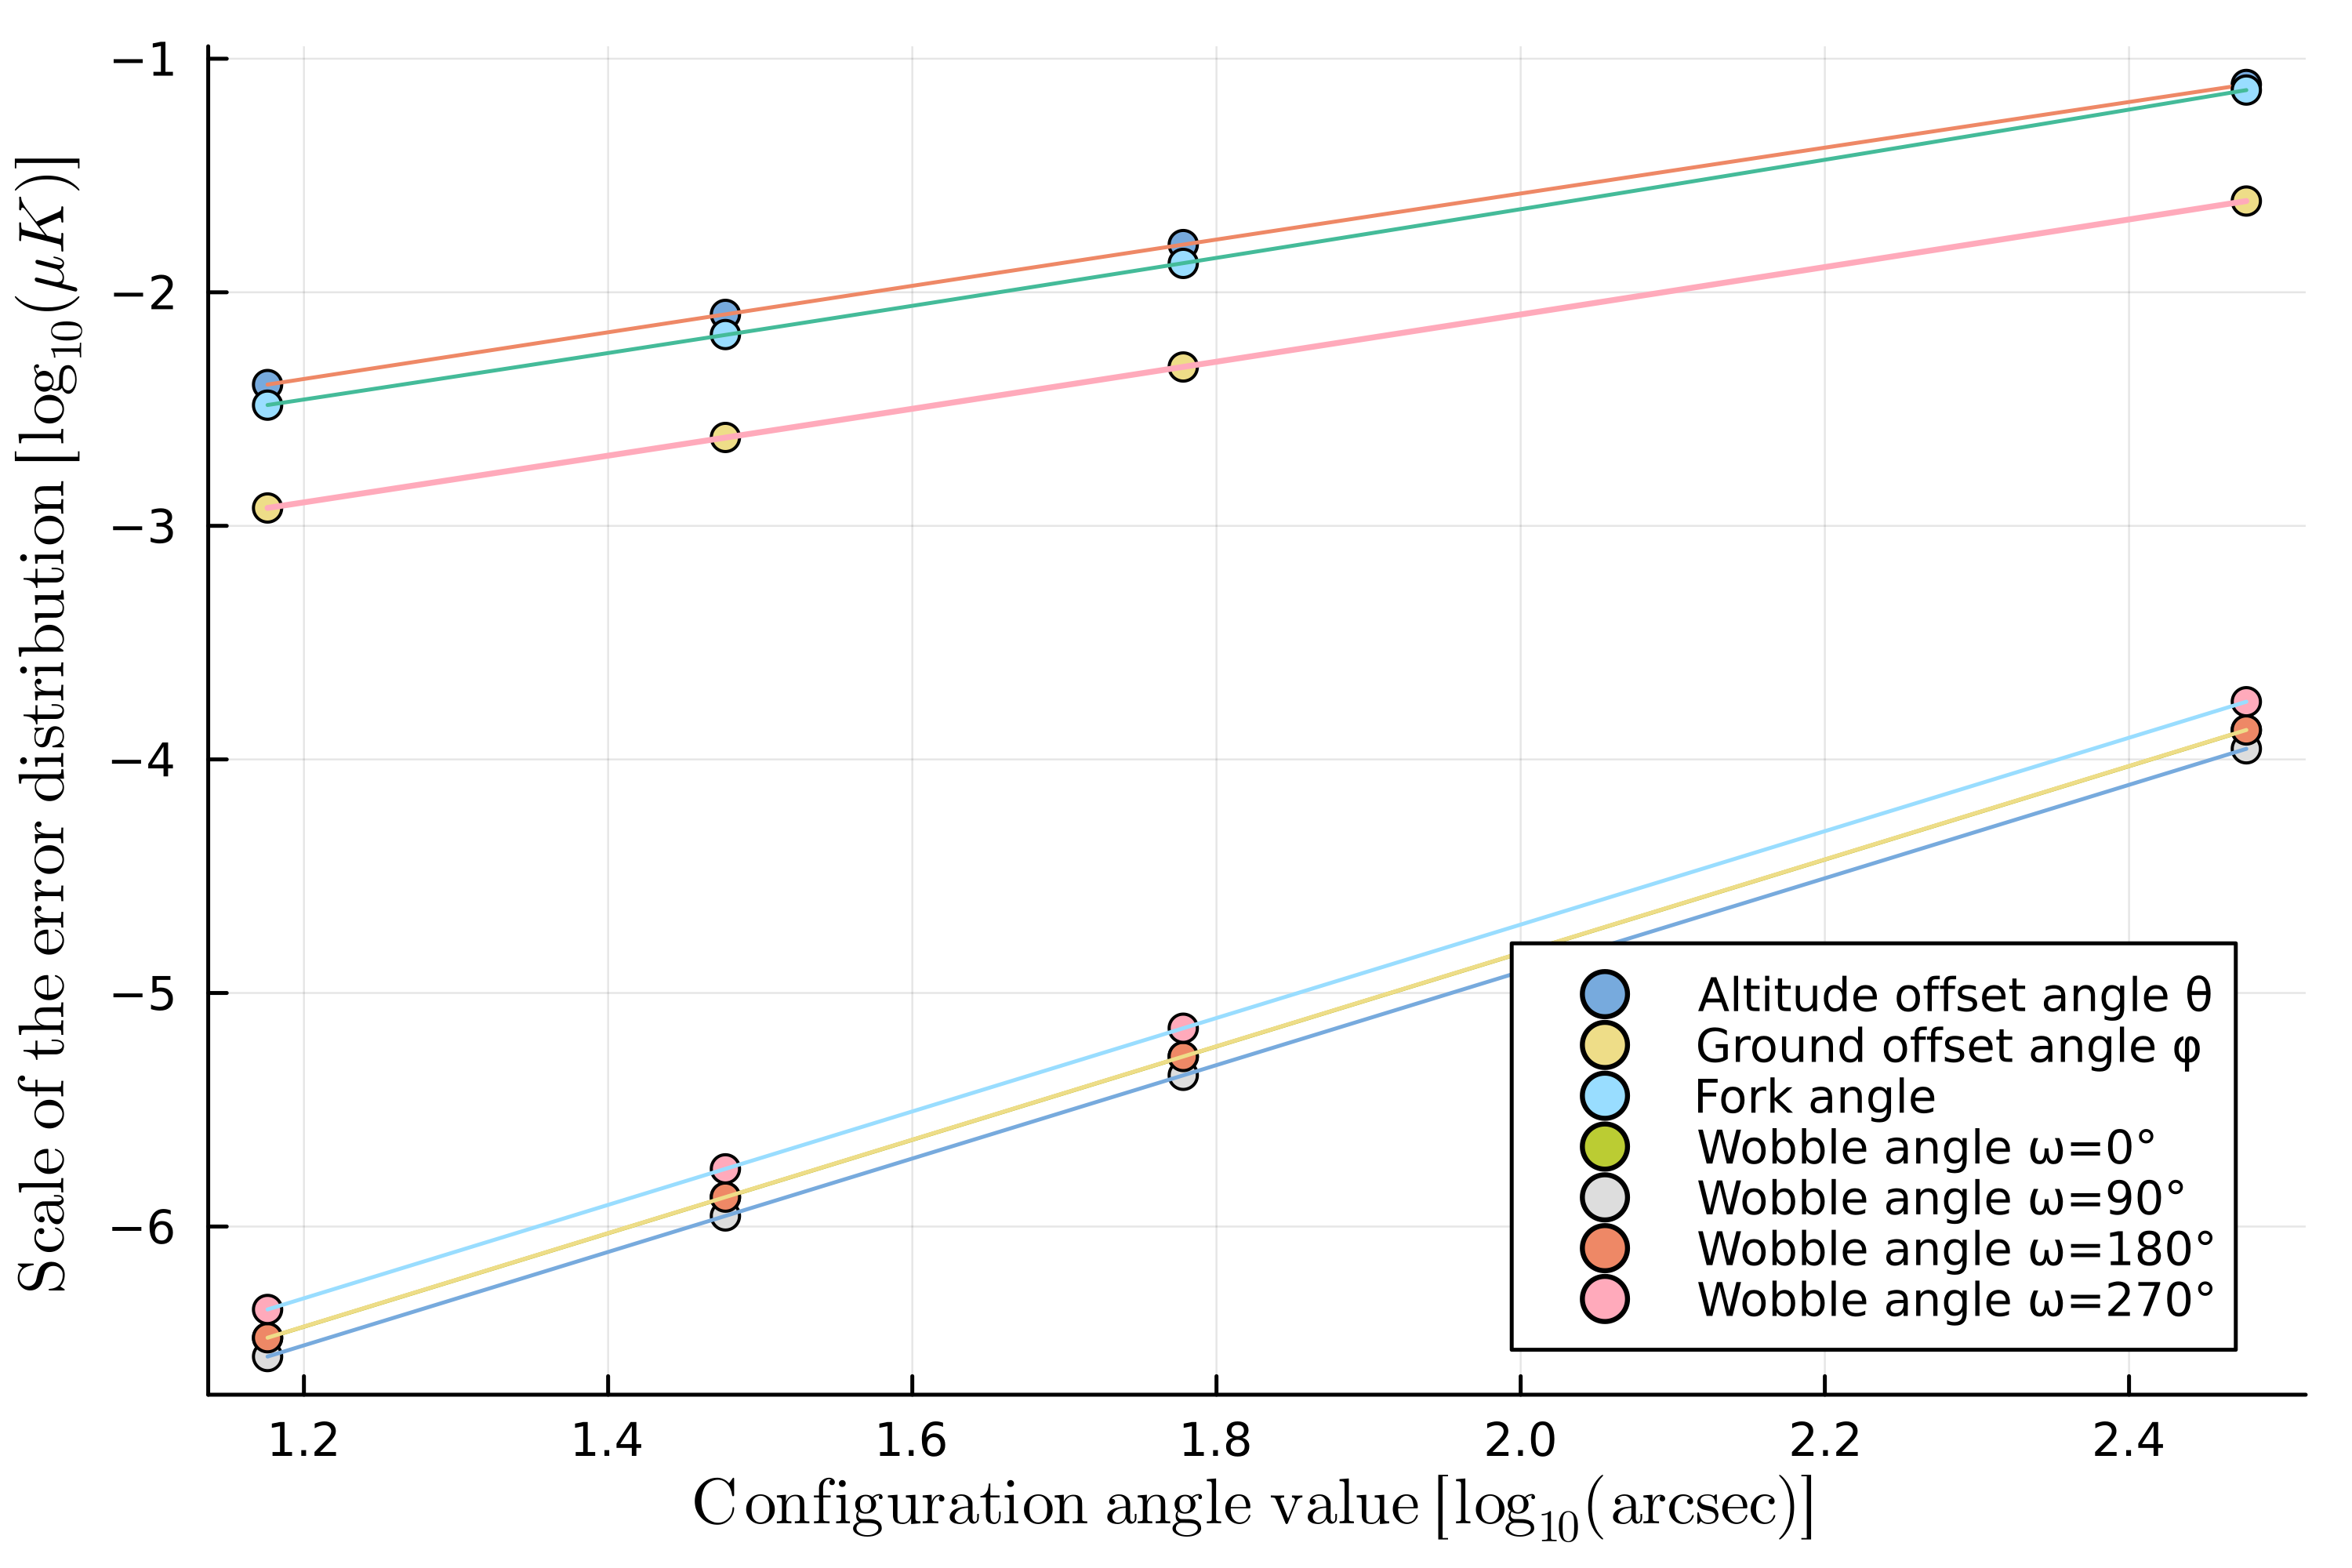

In [37]:

p = scatter!(log_angle, log_error_0, label = "Wobble angle ω=0°")
p = plot!(xdata, model_linear(xdata, fit_linear_0.param), label = false)

p = scatter!(log_angle, log_error_90, label = "Wobble angle ω=90°")
p = plot!(xdata, model_linear(xdata, fit_linear_90.param), label = false)

p = scatter!(log_angle, log_error_180, xlabel=xlabel, label = "Wobble angle ω=180°")
p = plot!(xdata, model_linear(xdata, fit_linear_180.param), label = false)

p = scatter!(log_angle, log_error_270, xlabel=xlabel, label = "Wobble angle ω=270°")
p = plot!(xdata, model_linear(xdata, fit_linear_270.param), label = false)

In [40]:
savefig("scaling/scaling.pdf")

"/mnt/sda1/Università/Magistrale/Tesi/Master-Thesis-Pipeline/notebooks/scaling/scaling.pdf"